In [1]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')


pixel_size_image = 299
IMAGE_SIZE = (pixel_size_image, pixel_size_image)  # All images contained in this dataset are pixel_size_imagexpixel_size_image (originally, to match Inception v3 input size)
SEED = 17

data_head_dir = Path('./data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('./train_source_images.txt')
validate_ids = load_text_ids('./val_source_images.txt')
test_ids = load_text_ids('./test_source_images.txt')


# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

import random
import tensorflow as tf
from PIL import Image 

import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from pathlib import Path

# Correct the function name from '_inner_function' to 'inner_function'
def load_and_preprocess(img_loc, label):
    def inner_function(img_loc, label):
        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        
        # Load image using PIL and convert to RGB
        img = Image.open(img_loc_str).convert('RGB')
        
        # Convert PIL image to numpy array
        img = np.array(img)
        img = tf.image.resize(img, [pixel_size_image, pixel_size_image])
        
        # Normalize the image to the [0, 1] range
        img = img / 255.0

        # Convert label to integer (assuming binary classification)
        label = 1 if label.numpy().decode('utf-8') == 'frost' else 0
        # label = tf.one_hot(label, depth=2)
        
        return img, label

    # Wrap the Python function
    X, y = tf.py_function(inner_function, [img_loc, label], [tf.float32, tf.int64])
    
    # Set the shape of the tensors
    X.set_shape([pixel_size_image, pixel_size_image, 3])
    y.set_shape([])  # Scalar label
    
    return X, y

def load_subdir_data(dir_path, image_size, seed=None):
    
    """Helper to create a TF dataset from each image subdirectory"""
    
    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')
    
    loc_list = []
    
    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
        
random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size) 

def augment_image(image, label):
    # Apply augmentation techniques
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    # Randomly rotate the image by 0, 90, 180, or 270 degrees
    # rotations = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    # image = tf.image.rot90(image, k=rotations)

    return image, label

# Ensure that the dataset is being augmented
tf_dataset_train_augmented = tf_dataset_train.map(augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

09:28:00 | WARNING | module_wrapper  | From C:\Users\krusa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.



In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.regularizers import l2

# Load the base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(pixel_size_image, pixel_size_image, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)  # Dropout rate of 30% as specified in the assignment
output = Dense(2, activation='softmax')(x)  # Use sigmoid for binary classification

# Final model setup
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(),  # Consider specifying the learning rate if necessary
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Note: The F1 Score needs to be calculated after model evaluation, not during compilation


09:28:02 | WARNING | module_wrapper  | From C:\Users\krusa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\backend.py:1398: The name tf.executing_eagerly_outside_functions is deprecated. Please use tf.compat.v1.executing_eagerly_outside_functions instead.

09:28:02 | WARNING | module_wrapper  | From C:\Users\krusa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\normalization\batch_normalization.py:979: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.



In [3]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=3,          # Stop after 3 epochs without improvement
    restore_best_weights=True  # Restore the weights from the epoch with the best value of the monitored metric
)

# Define the model checkpoint callback
model_checkpoint = ModelCheckpoint(
    'EfficientNetB0_best_model.h5',  # Path where to save the model
    save_best_only=True,  # Only save a model if `val_loss` has improved
    monitor='val_loss',
    mode='min'
)

# Compile your model with these callbacks
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

# Fit the model with the dataset
history = model.fit(
    tf_dataset_train_augmented,
    epochs=10,
    validation_data= tf_dataset_val,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/10


09:28:04 | WARNING | module_wrapper  | From C:\Users\krusa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\utils\tf_utils.py:492: The name tf.ragged.RaggedTensorValue is deprecated. Please use tf.compat.v1.ragged.RaggedTensorValue instead.

09:28:05 | WARNING | module_wrapper  | From C:\Users\krusa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\base_layer_utils.py:384: The name tf.executing_eagerly_outside_functions is deprecated. Please use tf.compat.v1.executing_eagerly_outside_functions instead.



928/928 [==============================] - ETA: 0s - loss: 0.7013 - accuracy: 0.5642 - precision_1: 0.5882 - recall_1: 0.8622

C:\Users\krusa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


928/928 [==============================] - 537s 573ms/step - loss: 0.7013 - accuracy: 0.5642 - precision_1: 0.5882 - recall_1: 0.8622 - val_loss: 0.8128 - val_accuracy: 0.3218 - val_precision_1: 0.3218 - val_recall_1: 1.0000
Epoch 2/10
928/928 [==============================] - 525s 565ms/step - loss: 0.6807 - accuracy: 0.5835 - precision_1: 0.5881 - recall_1: 0.9725 - val_loss: 0.7678 - val_accuracy: 0.3218 - val_precision_1: 0.3218 - val_recall_1: 1.0000
Epoch 3/10
928/928 [==============================] - 515s 555ms/step - loss: 0.6793 - accuracy: 0.5854 - precision_1: 0.5877 - recall_1: 0.9872 - val_loss: 0.8425 - val_accuracy: 0.3218 - val_precision_1: 0.3218 - val_recall_1: 1.0000
Epoch 4/10
928/928 [==============================] - 532s 573ms/step - loss: 0.6786 - accuracy: 0.5870 - precision_1: 0.5878 - recall_1: 0.9951 - val_loss: 0.7266 - val_accuracy: 0.3218 - val_precision_1: 0.3218 - val_recall_1: 1.0000
Epoch 5/10
928/928 [==============================] - 527s 567ms/st

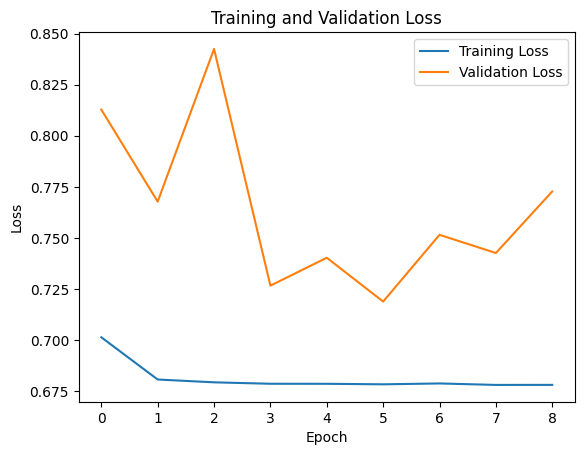

401/401 [==============================] - 159s 395ms/step - loss: 0.6745 - accuracy: 0.6555 - precision_1: 0.6555 - recall_1: 1.0000
Test Loss: 0.6744826436042786
Test Accuracy: 0.6554628610610962
Test Precision: 0.6554628610610962
Test Recall: 1.0
F1 Score: 0.7918786660559289


In [4]:
import matplotlib.pyplot as plt

# Ensure you have the history object from your model training
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

test_loss, test_accuracy, test_precision, test_recall = model.evaluate(tf_dataset_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")

# Calculate F1 Score
f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall) if (test_precision + test_recall) != 0 else 0
print(f"F1 Score: {f1_score}")

